In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import Table

import time as TIME
import os
import io
import requests  

from astropy.timeseries import LombScargle

#from pkg_resources import resource_filename
#from pyphot.astropy import UnitAscii_Library

#from pkg_resources import resource_filename
#from pyphot.astropy import UnitAscii_Library

#import dustapprox.literature.edr3

#where = resource_filename('dustapprox', 'data/Gaia2')
#lib = UnitAscii_Library([where])

from sklearn.model_selection import train_test_split

In [3]:
#Gaia.login()

## Problem 1 (get gaia data)

In [4]:
from joblib import Memory
cachedir = './joblib_cache'
memory = Memory(cachedir, verbose=0, bytes_limit=1e7)

In [5]:
query = """SELECT TOP 100
*

FROM gaiadr3.vari_rrlyrae 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40

AND pf IS NOT NULL 


"""
#vari_rrlyrae.num_clean_epochs_g
#AND vari_rrlyrae.num_clean_epochs_g >= 40


@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df

solution_id,source_id,pf,pf_error,p1_o,p1_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,epoch_rv,epoch_rv_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,average_rv,average_rv_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,peak_to_peak_rv,peak_to_peak_rv_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,num_clean_epochs_rv,zp_mag_g,zp_mag_bp,zp_mag_rp,num_harmonics_for_p1_g,num_harmonics_for_p1_bp,num_harmonics_for_p1_rp,num_harmonics_for_p1_rv,reference_time_g,reference_time_bp,reference_time_rp,reference_time_rv,fund_freq1,fund_freq1_error,fund_freq2,fund_freq2_error,fund_freq1_harmonic_ampl_g,fund_freq1_harmonic_ampl_g_error,fund_freq1_harmonic_phase_g,fund_freq1_harmonic_phase_g_error,fund_freq1_harmonic_ampl_bp,fund_freq1_harmonic_ampl_bp_error,fund_freq1_harmonic_phase_bp,fund_freq1_harmonic_phase_bp_error,fund_freq1_harmonic_ampl_rp,fund_freq1_harmonic_ampl_rp_error,fund_freq1_harmonic_phase_rp,fund_freq1_harmonic_phase_rp_error,fund_freq1_harmonic_ampl_rv,fund_freq1_harmonic_ampl_rv_error,fund_freq1_harmonic_phase_rv,fund_freq1_harmonic_phase_rv_error,best_classification,g_absorption,g_absorption_error
,,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,km / s,km / s,mag,mag,mag,mag,mag,mag,km / s,km / s,dex,dex,,,,,rad,rad,rad,rad,,,,,mag,mag,mag,,,,,d,d,d,d,1 / d,1 / d,1 / d,1 / d,mag,mag,rad,rad,mag,mag,rad,rad,mag,mag,rad,rad,km / s,km / s,rad,rad,,mag,mag
int64,int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,int16,int16,int16,int16,float64,float64,float64,float64,float64,float32,float64,float32,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str10,float32,float32
375316653866487565,245002531050576896,0.5205123049162365,5.9112863e-06,--,--,1705.1323363868853,8.359822e-06,1705.1414775254216,1.0046097e-05,1705.1311474358477,6.545865e-06,--,--,15.929145,0.010242176,16.356573,0.018603276,15.278727,0.009487258,--,--,0.9385019,0.120727494,1.0994217,0.10973381,0.8165013,0.06977717,--,--,-0.8708563,0.47518787,0.47389403,0.08163338,0.31729943,0.05761884,4.024685,0.12488823,2.1125093,0.25776532,45,44,44,--,15.964044,16.411121,15.302456,4,3,4,--,1706.5856067422114,1706.5859002172215,1706.585988363658,--,1.921184169048463,2.1818254e-05,--,--,[0.32880035042762756 0.15581652522087097 0.10432817041873932\n 0.06540334969758987 -- -- -- -- -- -- -- -- -- -- -- --],[0.014035544358193874 0.027286922559142113 0.023547401651740074\n 0.0244175773113966 -- -- -- -- -- -- -- -- -- -- -- --],[1.2044552564620972 0.15041014552116394 5.725874900817871 5.31508207321167\n 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.09733834117650986 0.12707017362117767 0.20258760452270508\n 0.42948588728904724 -- -- -- -- -- -- -- -- -- -- -- --],[0.42022404074668884 0.18070216476917267 0.13100408017635345 -- -- -- --\n -- -- -- -- -- -- -- -- --],[0.01920401118695736 0.024108218029141426 0.03326427564024925 -- -- -- --\n -- -- -- -- -- -- -- -- --],[1.2882311344146729 0.151897594332695 5.8355512619018555 0.0 0.0 0.0 0.0\n 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.09742680191993713 0.1614372581243515 0.2745889723300934 -- -- -- -- --\n -- -- -- -- -- -- -- --],[0.2656140923500061 0.14067623019218445 0.09007745236158371\n 0.06560894846916199 -- -- -- -- -- -- -- -- -- -- -- --],[0.010494326241314411 0.016995785757899284 0.016227422282099724\n 0.012636260129511356 -- -- -- -- -- -- -- -- -- -- -- --],[1.11

## Problem 2 (raw light curve)

In [6]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]


In [7]:
dl_key   = dl_keys[0]
product  = datalink[dl_key][0]
prod_tab = product.to_table()
prod_tab

source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
,,,d,mag,electron / s,electron / s,,,,,
int64,int64,object,float64,float64,float64,float64,float32,bool,bool,int64,int64
245002531050576896,17127455701357856,G,1706.5856067422114,16.212044183497525,6167.782826967349,18.128442302557097,340.22684,False,False,5,375316653866487564
245002531050576896,18963346597122114,G,1739.7894840400877,16.201074379828846,6230.415279264763,9.977831359467514,624.4258,False,False,1,375316653866487564
245002531050576896,18973087399306294,G,1739.9656540065293,15.674993272493136,10114.616892818458,18.68724706674014,541.25775,False,False,1,375316653866487564
245002531050576896,24162597315961460,G,1833.815905206406,15.812720101377455,8909.610249734831,22.796642677841945,390.82993,False,False,1,375316653866487564
245002531050576896,24166689644275234,G,1833.8899083171,16.02193380294584,7348.068997789167,21.78705243163637,337.2677,False,False,1,375316653866487564
245002531050576896,24771107999851979,G,1844.8197651805692,16.011649605906094,7418.001289023465,21.9161359994418,338.47214,False,False,1,375316653866487564
245002531050576896,24775200284660578,G,1844.893766641779,16.19119032991083,6287.393110514677,16.805708609639744,374.12247,False,False,1,375316653866487564
245002531050576896,26805533587595801,G,1881.6081701864985,15.410204293554555,12908.18049170981,29.43156331592016,438.58292,False,False,1,375316653866487564


In [8]:
def extract_dl_ind(datalink_dict, key, figsize = [15,5], fontsize = 12, linewidth = 2, show_legend = True, show_grid = True):
    ""
    "Extract individual DataLink products and export them to an Astropy Table"
    ""
    dl_out  = datalink_dict[key][0].to_table()
    if 'time' in dl_out.keys():
        plot_e_phot(dl_out, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = fontsize, show_legend = show_legend, show_grid = show_grid, figsize = figsize)
    if 'wavelength' in dl_out.keys():
        if len(dl_out) == 343:  title = 'XP Sampled'
        if len(dl_out) == 2401: title = 'RVS'
        plot_sampled_spec(dl_out, color = 'blue', title = title, fontsize = fontsize, show_legend = False, show_grid = show_grid, linewidth = linewidth, legend = '', figsize = figsize)
    return dl_out

def plot_e_phot(inp_table, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = 12, show_legend = True, show_grid = True, figsize = [15,5]):
    ""
    "Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    fig      = plt.figure(figsize=figsize)
    xlabel   = f'JD date [{inp_table["time"].unit}]'
    ylabel   = f'magnitude [{inp_table["mag"].unit}]'
    gbands   = ['G', 'RP', 'BP']
    colours  = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table['band'] == band]
        plt.plot(phot_set['time'], phot_set['mag'], 'o', label = band, color = next(colours))
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    plt.show()
    
def plot_sampled_spec(inp_table, color = 'blue', title = '', fontsize = 14, show_legend = True, show_grid = True, linewidth = 2, legend = '', figsize = [12,4], show_plot = True):
    ""
    "RVS & XP sampled spectrum plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    if show_plot:
        fig      = plt.figure(figsize=figsize)
    xlabel   = f'Wavelength [{inp_table["wavelength"].unit}]'
    ylabel   = f'Flux [{inp_table["flux"].unit}]'
    plt.plot(inp_table['wavelength'], inp_table['flux'], '-', linewidth = linewidth, label = legend)
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    if show_plot:
        plt.show()


def make_canvas(title = '', xlabel = '', ylabel = '', show_grid = False, show_legend = False, fontsize = 12):
    ""
    "Create generic canvas for plots"
    ""
    plt.title(title,    fontsize = fontsize)
    plt.xlabel(xlabel,  fontsize = fontsize)
    plt.ylabel(ylabel , fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize = fontsize*0.75)

Text(0, 0.5, 'Magnitude [mag]')

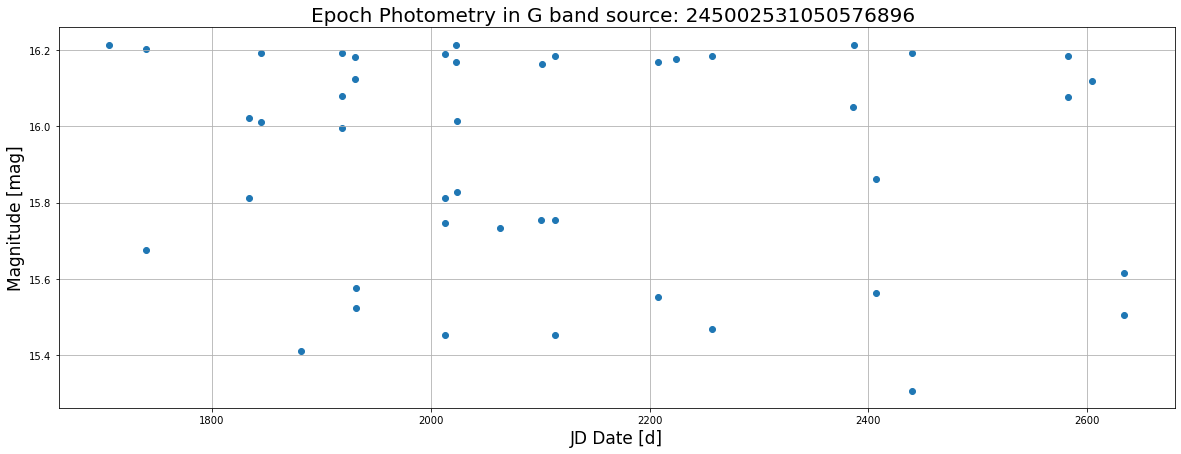

In [9]:
prod_tab.add_index('band')
t = prod_tab.loc['G']
t.sort('time')
time = np.array(t['time'])
mag = np.array(t['mag'])
source_id = t['source_id'][0]
fig = plt.figure(figsize = (20,7))
plt.grid()
plt.scatter(time, mag)
plt.title(f'Epoch Photometry in G band source: {source_id} ', size = 20)
plt.xlabel('JD Date [d]', size = 17)
plt.ylabel('Magnitude [mag]', size = 17)

## Problem 3 (lomb scargle)

Text(0.5, 1.0, 'Periodogram (souce: 245002531050576896)')

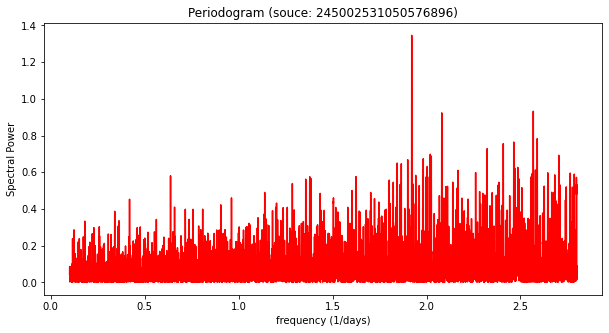

In [10]:
freq, p_ls = LombScargle(time, mag, fit_mean=False, center_data=True).autopower(minimum_frequency=0.1,
                                         maximum_frequency=2.8,
                                         normalization='psd',
                                         samples_per_peak=5)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(freq, p_ls, 'r-')
ax.set_ylabel('Spectral Power')
ax.set_xlabel('frequency (1/days)')
ax.set_title(f'Periodogram (souce: {source_id})')

## Problem 4 (Estimated mean mag and period)

In [11]:
def estimate_period(freq, p_ls):
    max_value = np.nanmax(p_ls)
    index = np.where(p_ls == max_value)[0][0]
    return 1/freq[index]

def get_lomb_scargle(time, mag):
    freq, p_ls = LombScargle(time, mag, fit_mean=False, center_data=True).autopower(minimum_frequency=0,
                                         maximum_frequency=3,
                                         normalization='psd',
                                         samples_per_peak=5)
    return freq, p_ls

def get_time_mag(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    time = np.array(t['time'])
    mag = np.array(t['mag'])
        
    return time, mag

def get_period(dl_key):
    time, mag = get_time_mag(dl_key)
    freq, p_ls = get_lomb_scargle(time, mag)
    
    return estimate_period(freq, p_ls)

def estimate_mean_mag(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    mag = np.array(t['mag'])
    
    converted_mag = []
    for i in range(len(mag)):
        converted_mag.append(10**(mag[i]/(-2.5)))
    
    return (-2.5)*np.log10(np.mean(converted_mag))

def get_source_id(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    source_id = t['source_id'][0]
    return source_id
    
def plot_epoch_phot(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()

    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    time = np.array(t['time'])
    mag = np.array(t['mag'])
    source_id = t['source_id'][0]
    fig = plt.figure(figsize = (20,7))
    plt.grid()
    plt.scatter(time, mag)
    plt.title(f'Epoch Photometry in G band, Source ID: {source_id} ', size = 20)
    plt.xlabel('JD Date [d]', size = 17)
    plt.ylabel('Magnitude [mag]', size = 17)
    
def plot_lomb_scargle(dl_key):
    time, mag = get_time_mag(dl_key)
    freq, p_ls = LombScargle(time, mag, fit_mean=False, center_data=True).autopower(minimum_frequency=0.1,
                                         maximum_frequency=2.8,
                                         normalization='psd',
                                         samples_per_peak=5)
    fig, ax = plt.subplots(1, figsize=(10, 5))
    source_id = get_source_id(dl_key)
    ax.plot(freq, p_ls, 'r-')
    ax.set_ylabel('Spectral Power')
    ax.set_xlabel('frequency (1/days)')
    ax.set_title(f'Periodogram, Source ID: {source_id})')
    

def plot_phase_phot(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    time = np.array(t['time'])
    mag = np.array(t['mag'])
    source_id = t['source_id'][0]
    fig = plt.figure(figsize = (20,7))
    period = get_period(dl_key)
    plt.grid()
    plt.scatter(time%period, mag, label = 'phased light curve')
    plt.title(f'Phase Photometry in G band, Source ID: {source_id} ', size = 20)
    plt.xlabel('Phase [d]', size = 17)
    plt.ylabel('Magnitude [mag]', size = 17)

In [12]:
source_ids = []
estimated_mean_mags = []
estimated_periods = []

for dl_key in dl_keys:
    source_ids.append(get_source_id(dl_key))
    estimated_mean_mags.append(estimate_mean_mag(dl_key))
    estimated_periods.append(get_period(dl_key))



/srv/conda/envs/notebook/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)


In [13]:
d = {'source_ids': source_ids, 'estimated_mean_mag': estimated_mean_mags, 'estimated_periods': estimated_periods}
df2 = pd.DataFrame(data=d)
#df2.sort_values('estimated_periods', ascending = False)
df2

,source_ids,estimated_mean_mag,estimated_periods
0,245002531050576896,15.870378,0.520487
1,245504251951140864,17.969103,0.507130
2,245823861938360064,19.323328,0.478795
3,246756973652292992,12.312440,0.489275
4,359112665277840512,15.913452,0.501785
...,...,...,...
95,2195648132814029312,19.057905,0.501509
96,2195750146876812032,19.220153,0.620648
97,2195878209919982464,17.634512,0.566641
98,2195880752540525952,16.566697,0.749045


the estimated periods are comparable to those reported in the vari_rrlyrae catalog

## Problem 5 (fourier decomp algorithm)

In [14]:
def construct_X_matrix(T, K, P):
    X = []
    
    w = (2*np.pi)/P
    
    for t in T:
        row = []
        row.append(1)
        for k in range(K):
            row.append(np.sin((k+1)*w*t))
            row.append(np.cos((k+1)*w*t))
         
        X.append(row)
        
    return X

def least_squares(X, b):
    
    return np.linalg.lstsq(X , b, rcond=None)

def reconstructed_f(coef, t, K, P):
        
    w = (2*np.pi)/P
    X = []
    X.append(1)
    for k in range(K):
        X.append(np.sin((k+1)*w*t))
        X.append(np.cos((k+1)*w*t))
    
    return np.matmul(X, np.transpose(coef))

def plot_fourier_decomp(dl_key, k):
    time, mag = get_time_mag(dl_key)
    period = get_period(dl_key)
    plot_phase_phot(dl_key)

    b = mag
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    t = np.linspace(0, period, 200)
    f = reconstructed_f(coef, t, k, period)

    plt.plot(t, f, label = f'K = {k}')
    plt.legend(prop={'size': 15})
    
    return f



$\beta$ is a vector of unknowns $[A_o, a_1, b_1, a_2, b_2, a_3, b_3 ...]$ with 2K+1 elements

## Problem 6 (fourier decomp of high resolution source)

period: 0.4743917357308307
mean mag: 16.1933620807742


/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


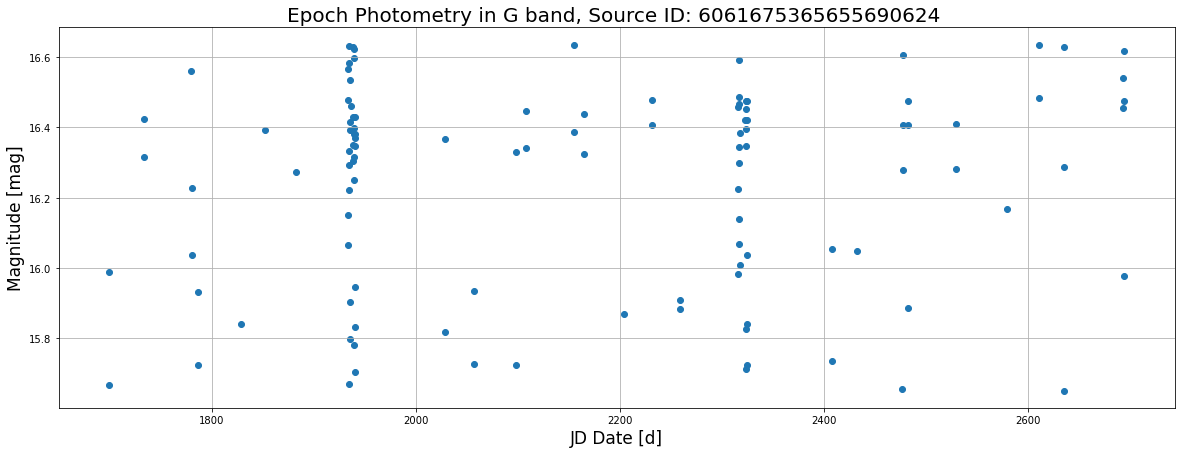

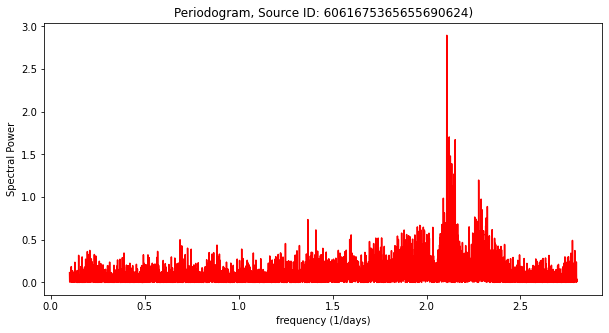

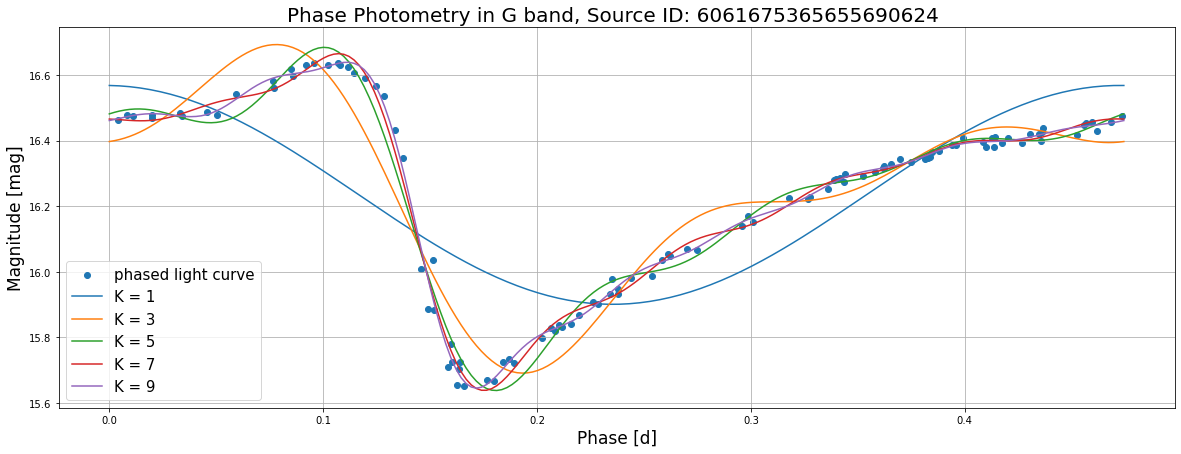

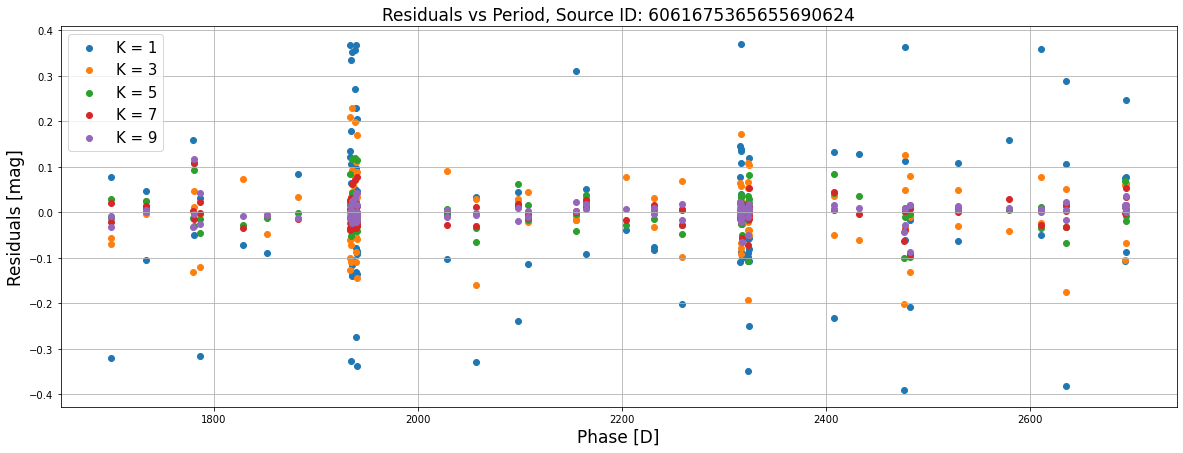

In [15]:
#find highest s/n ratio

pf = np.array(df['pf'])
pf_error = np.array(df['pf_error'])
sn_ratio = pf/pf_error
max_sn_ratio = np.nanmax(sn_ratio)
index = np.where(sn_ratio == max_sn_ratio)
index = index[0][0]
dl_key = dl_keys[index]

#initial plots

plot_epoch_phot(dl_key)
plot_lomb_scargle(dl_key)

period = get_period(dl_key)
estimate_mean_mag(dl_key)
source_id = get_source_id(dl_key)
print('period:',period)
print('mean mag:',estimate_mean_mag(dl_key))

#series representations

time, mag = get_time_mag(dl_key)
plot_phase_phot(dl_key)

b = mag
K = [1,3,5,7,9]
for k in K:
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    t = np.linspace(0, period, 200)
    f = reconstructed_f(coef, t, k, period)

    plt.plot(t, f, label = f'K = {k}')
plt.legend(prop={'size': 15})

#plot residuals 
plt.figure(figsize = (20,7))

for k in K:
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    f = reconstructed_f(coef, time, k, period)
    
    
    plt.scatter(time,mag - f, label = f'K = {k}')

plt.title(f'Residuals vs Period, Source ID: {source_id}', size = 17)
plt.grid()
plt.xlabel('Phase [D]', size = 17)
plt.ylabel('Residuals [mag]', size = 17)
plt.legend(prop={'size': 15})



## Problem 7 (chi^2 for K) 

/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


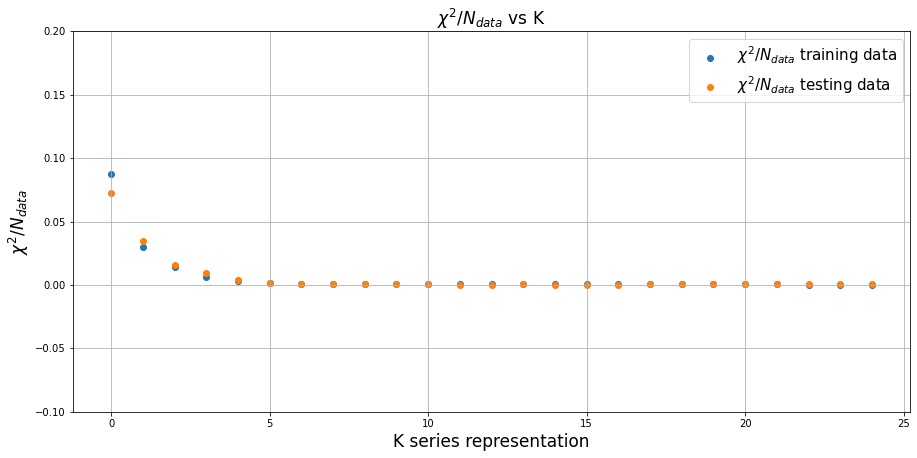

In [16]:

dl_key = dl_keys[index]
period = get_period(dl_key)

#split data into training and test

time, mag = get_time_mag(dl_key)

time_train, time_test, mag_train, mag_test = train_test_split(time, mag, train_size = 0.8, random_state = 42)

b = mag_train
K = [x for x in range(25)]
chi2s_train = []
chi2s_test = []
for k in K:
    X = construct_X_matrix(time_train, k, period)
    coef, residuals, rank, s = least_squares(X, b)
    
    #training
    f_train = reconstructed_f(coef, time_train, k, period)
    chi2_train = np.sum((mag_train-f_train)**2) / len(time_train)
    chi2s_train.append(chi2_train)
    
    #testing
    f_test = reconstructed_f(coef, time_test, k, period)
    chi2_test = np.sum((mag_test-f_test)**2) / len(time_test)
    chi2s_test.append(chi2_test)
    
plt.figure(figsize = (15,7))
plt.scatter(K, chi2s_train, label = '$\chi^2 / N_{data}$ training data')
plt.scatter(K, chi2s_test, label = '$\chi^2 / N_{data}$ testing data')
plt.grid()
plt.title('$\chi^2 / N_{data}$ vs K',size = 17)
plt.xlabel('K series representation',size = 17)
plt.ylabel('$\chi^2 / N_{data}$',size = 17)
plt.ylim(-0.1,0.2)
plt.legend(prop={'size': 15})


## Problem 8 (light curve extrapolation)

/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


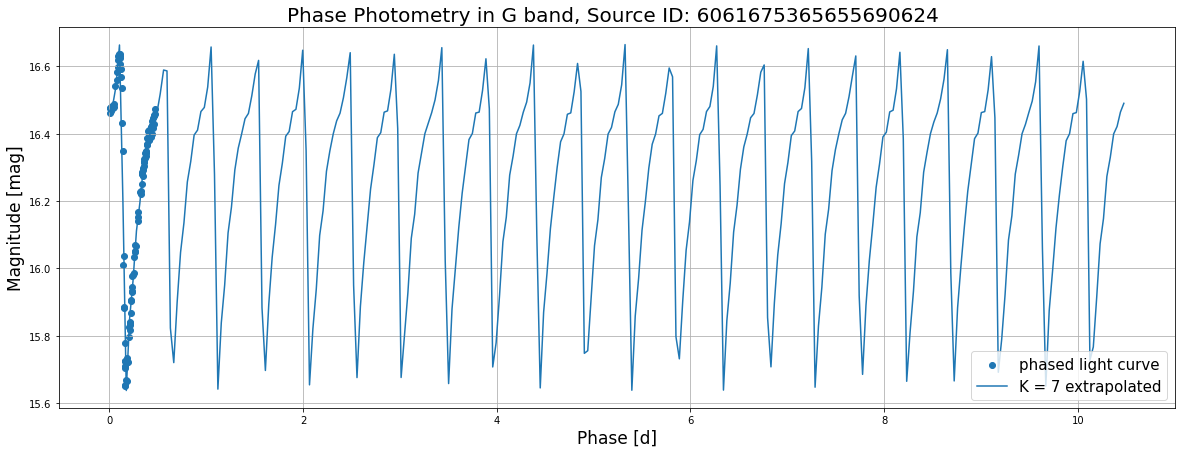

In [17]:
#extrapolation
dl_key = dl_keys[index]
period = get_period(dl_key)

time, mag = get_time_mag(dl_key)
plot_phase_phot(dl_key)

b = mag
k = 7

X = construct_X_matrix(time, k, period)
coef, residuals, rank, s = least_squares(X, b)

t = np.linspace(0, period+10, 300)
f = reconstructed_f(coef, t, k, period)
plt.plot(t, f, label = f'K = {k} extrapolated')
plt.legend(prop={'size': 15})



## Problem 9 (Accurate Mean Mag from fourier decomp)

In [18]:
def fourier_decomp(dl_key, k, samples = 200):
    time, mag = get_time_mag(dl_key)
    period = get_period(dl_key)
    b = mag
    
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    t = np.linspace(0, period, samples)
    f = reconstructed_f(coef, t, k, period)
    return f
    
def get_fourier_mean_mag(f):
    converted_mag = []
    for i in range(len(f)):
        converted_mag.append(10**(f[i]/(-2.5)))
        
    return (-2.5)*np.log10(np.mean(converted_mag))

def get_absolute_mag(dl_key, d):
    f = fourier_decomp(dl_key , 7)
    m = get_fourier_mean_mag(f)   
    
    M = m - 5*np.log10(d) + 5
    return M


In [19]:
source_ids = []
fourier_mean_mags = []
k = 7

for dl_key in dl_keys:
    source_ids.append(get_source_id(dl_key))
    f = fourier_decomp(dl_key, k, samples = 200)
    fourier_mean_mag = get_fourier_mean_mag(f)
    
    fourier_mean_mags.append(fourier_mean_mag)

d = {'source_ids': source_ids, 'fourier_mean_mag': fourier_mean_mags}
df3 = pd.DataFrame(data=d)
#df2.sort_values('estimated_periods', ascending = False)
df3

/srv/conda/envs/notebook/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)
/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


,source_ids,fourier_mean_mag
0,245002531050576896,15.857052
1,245504251951140864,17.990431
2,245823861938360064,19.337150
3,246756973652292992,12.355293
4,359112665277840512,15.905017
...,...,...
95,2195648132814029312,19.068327
96,2195750146876812032,19.203695
97,2195878209919982464,17.621507
98,2195880752540525952,16.563064


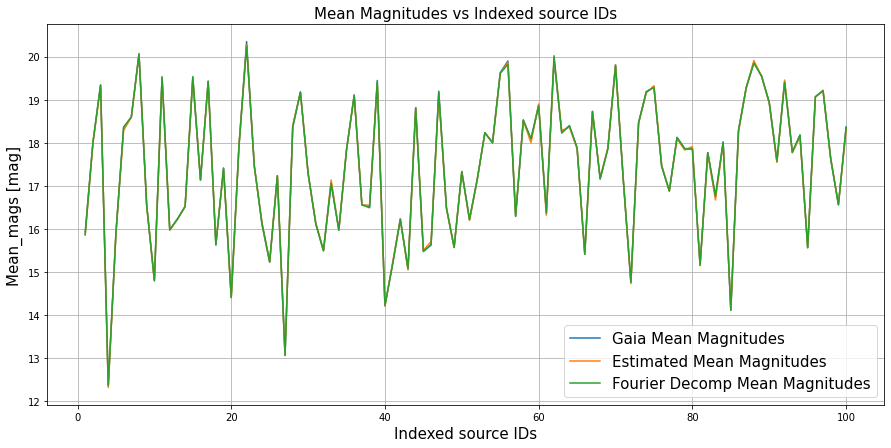

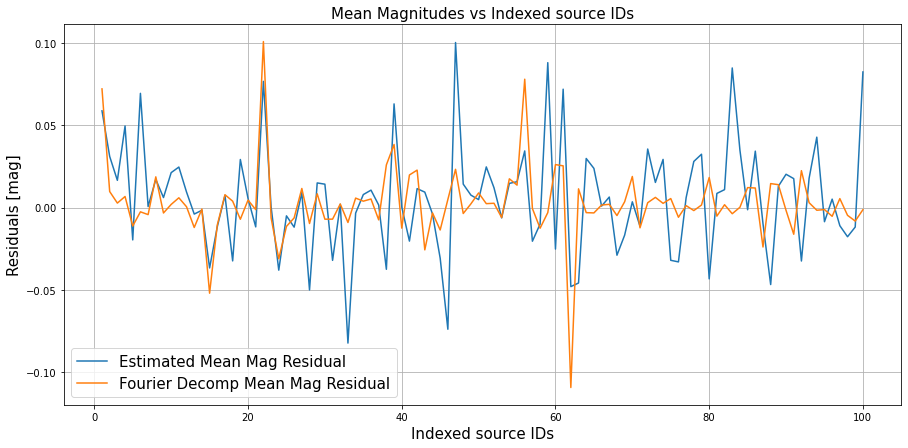

In [20]:
# plot comparisons 

gaia_mean_mags = df['int_average_g']

plt.figure(figsize = (15, 7))
x = np.linspace(1,100, 100)
plt.plot(x, gaia_mean_mags, label = 'Gaia Mean Magnitudes')
plt.plot(x, estimated_mean_mags, label = 'Estimated Mean Magnitudes')
plt.plot(x, fourier_mean_mags, label = 'Fourier Decomp Mean Magnitudes')
plt.grid()
plt.xlabel('Indexed source IDs', size = 15)
plt.ylabel('Mean_mags [mag]', size = 15)
plt.title('Mean Magnitudes vs Indexed source IDs', size = 15)
plt.legend(prop={'size': 15})

#plot residuals
plt.figure(figsize = (15, 7))
plt.plot(x, gaia_mean_mags - estimated_mean_mags, label = 'Estimated Mean Mag Residual')
plt.plot(x, gaia_mean_mags - fourier_mean_mags, label = 'Fourier Decomp Mean Mag Residual')
plt.grid()
plt.xlabel('Indexed source IDs', size = 15)
plt.ylabel('Residuals [mag]', size = 15)
plt.title('Mean Magnitudes vs Indexed source IDs', size = 15)
plt.legend(prop={'size': 15})

The residuals are smaller for most sources but there are still peaks that follow the estimated means from the raw data, indicating that our data is giving limited results in which our fourier decomposition is being affected

## Problem 10 (RRc  and RRab comparison)

In [21]:
#query gaia database for RRc

query_RRc = """SELECT TOP 3
*

FROM gaiadr3.vari_rrlyrae 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 80
AND gaiadr3.vari_rrlyrae.int_average_g >= 15
AND best_classification = 'RRc'

"""

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df_RRc = get_gaia_query(query_RRc)

/srv/conda/envs/notebook/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)
/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


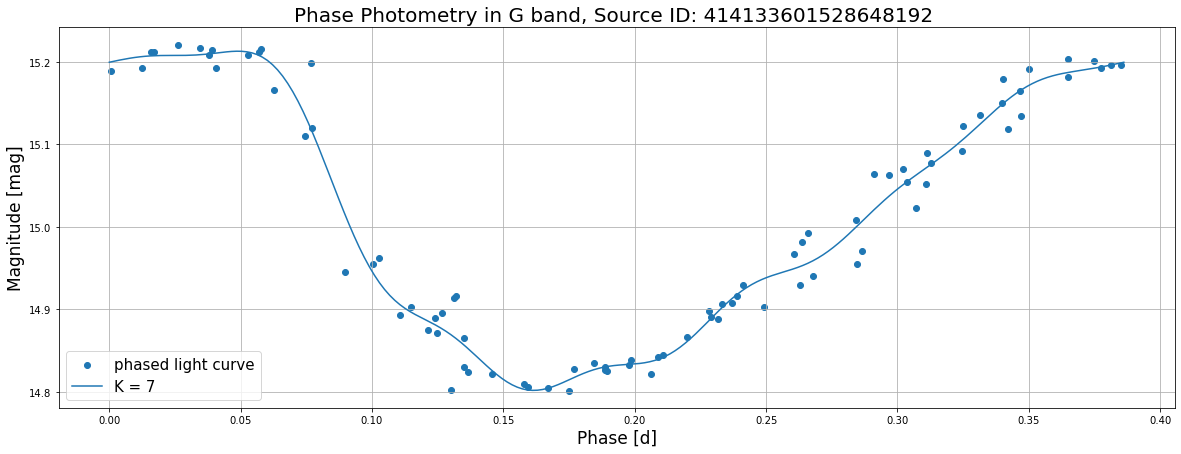

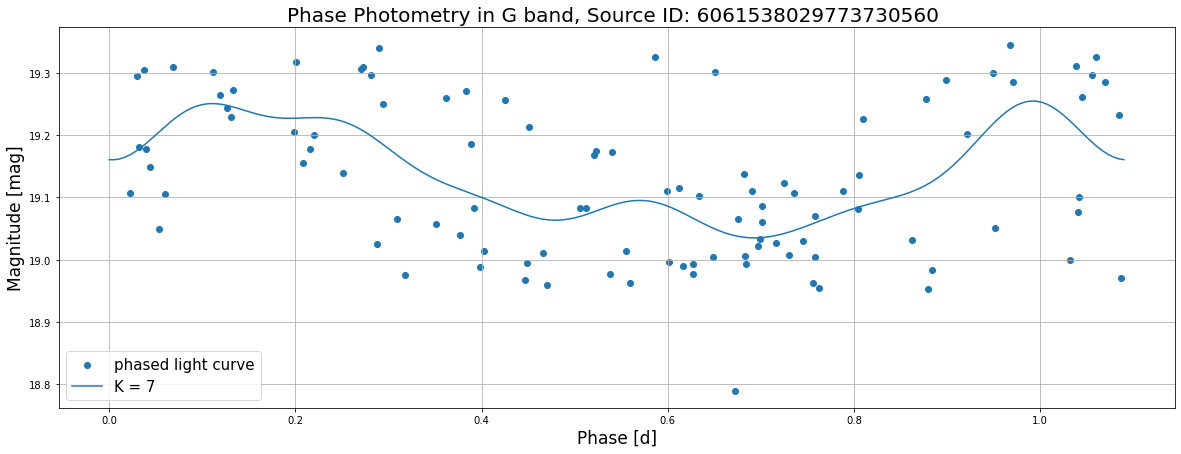

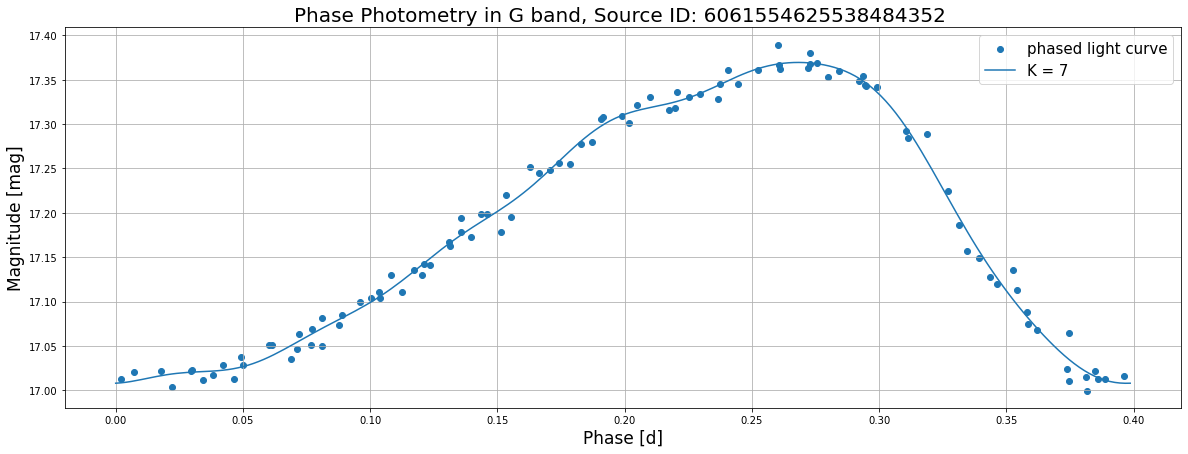

In [22]:
#get light curves of RRc

retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df_RRc['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys_RRc  = [inp for inp in datalink.keys()]

dl_keys_RRc

#plot phase and fourier decomp

for dl_key in dl_keys_RRc:
    plot_fourier_decomp(dl_key, 7)
    
#STREAMLINE

In [23]:
#query gaia database for RRab
query_RRab = """SELECT TOP 3
*

FROM gaiadr3.vari_rrlyrae 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 80
AND gaiadr3.vari_rrlyrae.int_average_g >= 15
AND best_classification = 'RRab'

"""
@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df_RRab = get_gaia_query(query_RRab)

/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


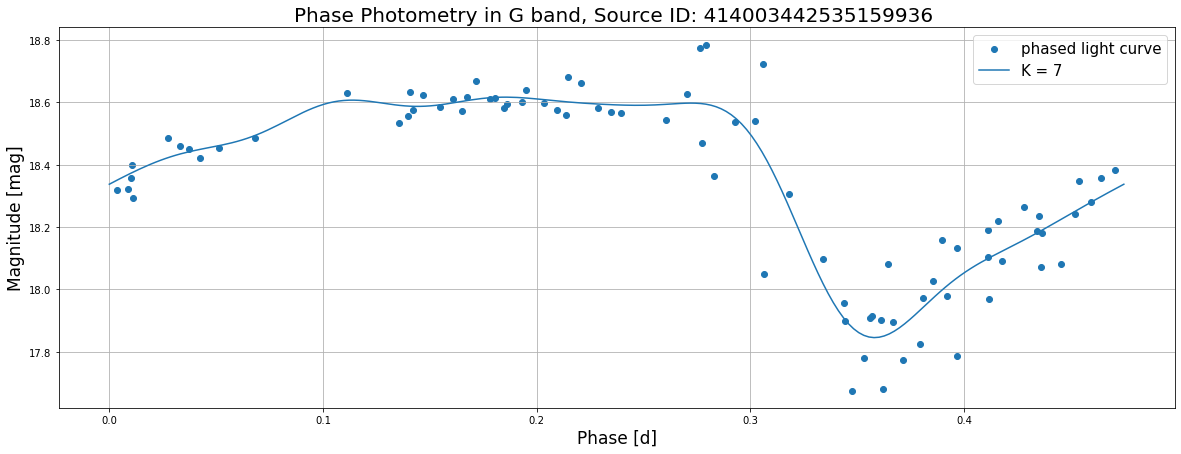

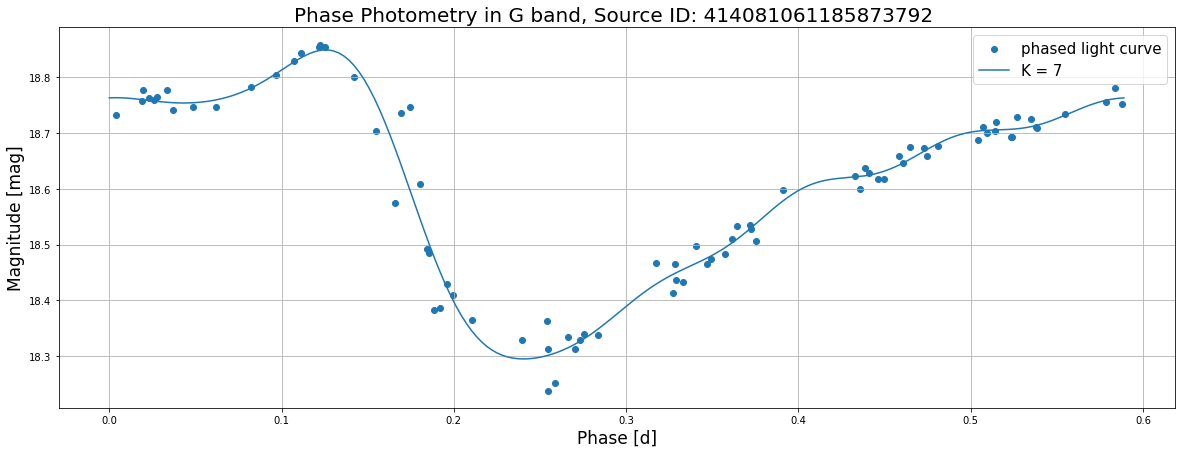

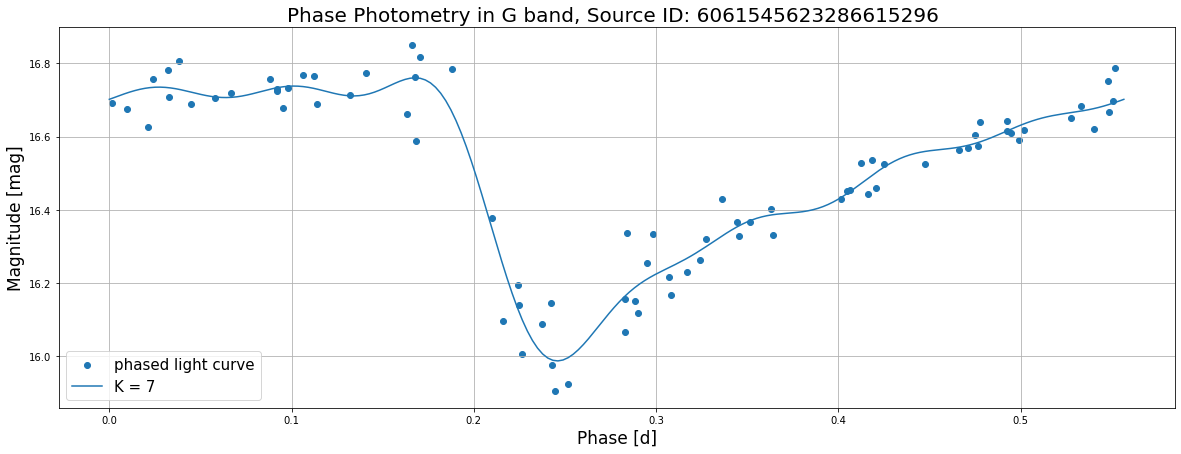

In [24]:
#get light curves of RRab

retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df_RRab['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys_RRab  = [inp for inp in datalink.keys()]

dl_keys_RRab

#plot phase and fourier decomp

for dl_key in dl_keys_RRab:
    plot_fourier_decomp(dl_key, 7)
    
#STREAMLINE

The RRab class of RR Lyrae stars have a characteristic sharp dip in magnitude in which it quickly rises again, with a negative concavity. The RRc class has a similar sharp magnitude dip, but the way in which it rises appears to be slower, having positive concavity.

http://ogle.astrouw.edu.pl/atlas/RR_Lyr.html

## Problem 11 (Blazhko effect)

There is a significant intrinsic scatter in the phase plot of the second RRc source. RRc stars exhibit changes in pulsation periods. (First overtone pulsators)

Netzel et al. 2018: https://arxiv.org/pdf/1812.05409.pdf
- 'Blazhko effect is quasi-periodic modulation of am- plitude and/or phase of a subgroup of RR Lyrae stars'

## Problem 12 (new query outside disk)

In [25]:
#new query
querydr2 = """SELECT 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)

JOIN gaiaedr3.dr2_neighborhood AS dr3xdr2
ON dr3xdr2.dr3_source_id = gaia_source.source_id 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25


AND pf IS NOT NULL 


"""

'JOIN gaiaedr3.gaia_source USING (source_id)'


query = """SELECT TOP 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id) 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25


AND pf IS NOT NULL 


"""


@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df

source_id,parallax,parallax_over_error,b,pf,pf_error,int_average_g,int_average_g_error
,mas,,deg,d,d,mag,mag
int64,float64,float32,float64,float64,float32,float32,float32
5082275006547809536,0.26809523957285347,16.220354,-51.47302371332451,0.5599589021541818,2.247266e-06,13.462838,0.003699631
5083238071357950336,0.3829277675273604,1.3748403,-48.055472524594585,0.5597399771638871,4.9307782e-06,19.604332,0.006446325
5083946363004134144,0.5946781130908292,34.110825,-49.8322488970572,0.49750448582774803,2.4864212e-06,12.052523,0.0041959034
5094203642556959744,0.5017024595959433,24.04988,-45.693940849004406,0.6088124847419696,1.978491e-06,11.987591,0.0063922284
5094426804761045248,0.4086511433886336,26.117859,-46.35806582585982,0.6021733362599567,5.8916344e-06,12.443733,0.010910096
5098240155900394112,0.36106562106170625,20.336185,-55.33792695831056,0.629624359508207,8.102741e-06,12.518427,0.01379541
4658071252932747008,0.2983910008107831,1.557971,-32.659719621426795,0.5056045805490074,7.385649e-06,19.227907,0.019217765
4658085821547585024,1.0071331974362467,3.7954788,-32.90352017926716,0.6414111994763185,2.1240417e-05,19.038399,0.03759266


Source IDs might change between the dr2 and dr3 catalog when there is a misidentification of sources at one location, for example two sources being interpreted as one or the other way around. Torra et al., 2020 https://arxiv.org/abs/2012.06420

## Problem 13 (Bailer Jones Distances)

Bailer-Jones et al, 2020: https://arxiv.org/pdf/2012.05220.pdf

In [26]:
#new query
query = """SELECT TOP 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10


AND pf IS NOT NULL 


"""
'''JOIN external.gaiaedr3_distance USING (source_id)
gaiaedr3_distance.r_med_geo
gaiaedr3_distance.r_hi_geo
gaiaedr3_distance.r_hi_geo
'''

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df

source_id,parallax,parallax_over_error,b,l,pf,pf_error,int_average_g,int_average_g_error,r_med_geo,r_hi_geo,r_lo_geo
,mas,,deg,deg,d,d,mag,mag,pc,pc,pc
int64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32
5082275006547809536,0.26809523957285347,16.220354,-51.47302371332451,219.87363079008162,0.5599589021541818,2.247266e-06,13.462838,0.003699631,3251.9053,3426.7776,3081.9224
5083946363004134144,0.5946781130908292,34.110825,-49.8322488970572,218.64881795286897,0.49750448582774803,2.4864212e-06,12.052523,0.0041959034,1607.3054,1652.5009,1558.1212
5094203642556959744,0.5017024595959433,24.04988,-45.693940849004406,214.1579182947437,0.6088124847419696,1.978491e-06,11.987591,0.0063922284,1885.8368,1978.6187,1809.5858
5094426804761045248,0.4086511433886336,26.117859,-46.35806582585982,213.79029199767078,0.6021733362599567,5.8916344e-06,12.443733,0.010910096,2297.7349,2390.4333,2213.6853
5098240155900394112,0.36106562106170625,20.336185,-55.33792695831056,215.75720474779882,0.629624359508207,8.102741e-06,12.518427,0.01379541,2607.2856,2714.123,2500.5015
584371601026374272,0.5023216203946383,29.193705,30.31802198627761,221.77253179679283,0.636424023604154,2.2620877e-06,12.259682,0.0019192556,1884.4073,1942.4014,1837.6722
586254622063844736,0.413362843606383,23.04635,38.44674515040859,226.041203484812,0.6028511675471729,3.140523e-06,12.420674,0.0035330036,2271.9607,2378.0483,2172.1985
3844396540563624832,0.613325049466868,29.34836,35.20937516561878,231.9936973061365,0.6343515568959289,3.3973001e-06,11.697707,0.0032393388,1524.2205,1566.2969,1467.515


A posterior distribution is calculated by using a distance prior (gamma function) which has an exponentially decreases with a characteristic length scale that is direction dependent. The likelihood is an assumed Gaussian that depends on the parallax zero point. The posterior distribution is calculated numerically using MCMC. r_hi_geo - r_lo_geo represents the 68% confidence interval in which r_med_geo is the median of the distribution.  Relation between parallax and distance requires a non linear transfromation. As parallax measurements are smaller, the errors on distances become large.

## Problem 14 (Bailer Jones vs EDR3 Parallax) 

Text(0.5, 1.0, 'Location of Sources in Galactic Coordinates')

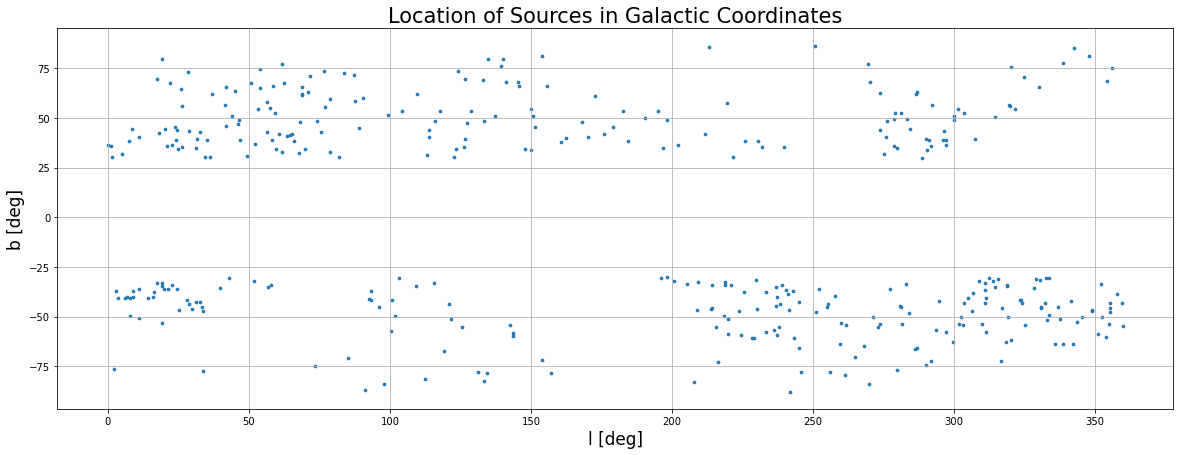

In [27]:
bs = df['b']
ls = df['l']

plt.figure(figsize = (20,7))
plt.scatter(ls, bs, s = 7)
plt.grid()
plt.xlabel('l [deg]', size = 17)
plt.ylabel('b [deg]', size = 17)
plt.title('Location of Sources in Galactic Coordinates', size = 21)

(0.0, 5000.0)

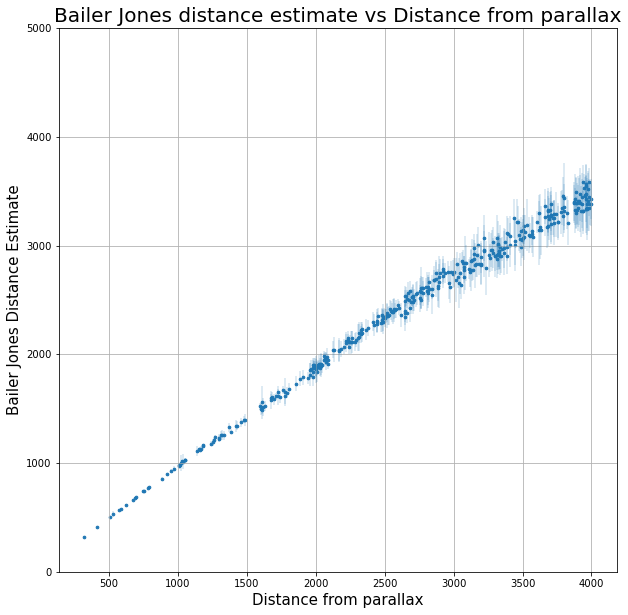

In [28]:
#plot distance estimate and parallax 
r_med_geos = df['r_med_geo']
parallaxes = df['parallax']
parallax_distances = 1/parallaxes * 1000

plt.figure(figsize = (10,10))
plt.grid()
plt.scatter(parallax_distances,r_med_geos,  s = 7)

bailer_jones_errors = (df['r_hi_geo'] - df['r_lo_geo'])/2

plt.errorbar(parallax_distances, r_med_geos, yerr = bailer_jones_errors, fmt = 'none', elinewidth = 0.3)

plt.ylabel('Bailer Jones Distance Estimate', size = 15)
plt.xlabel('Distance from parallax', size = 15)
plt.title('Bailer Jones distance estimate vs Distance from parallax', size = 20)
plt.ylim(0,5000)

As the distances get larger, there is a greater discrepancy between the Bailer Jones distance and the distance calculated from parallax, indicating that the parallax uncertainties become larger.

## Problem 15 (Plot period vs G band magnitude)

In [29]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]



In [30]:
periods = []
G_band_absolute_magnitudes = []
for dl_key in dl_keys:
    periods.append(get_period(dl_key))
    source_id = get_source_id(dl_key)
    
    df.add_index('source_id')
    t = df.loc[source_id]
    d = t['r_med_geo']
    
    absolute_mags = get_absolute_mag(dl_key, d)
    G_band_absolute_magnitudes.append(absolute_mags)



/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


Text(0.5, 1.0, 'Absolute Magnitude vs. Period')

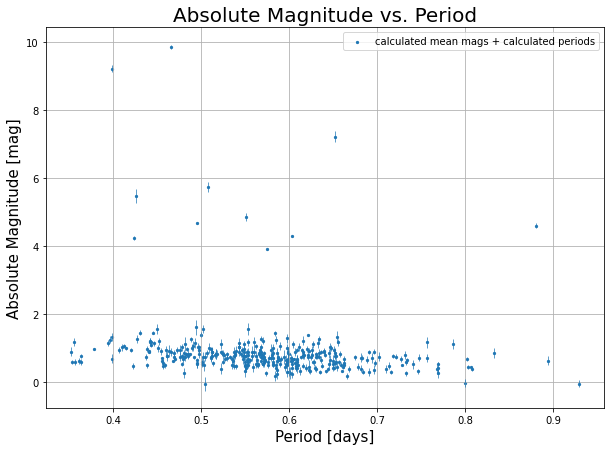

In [31]:
plt.figure(figsize = (10,7))
bailer_jones_d = df['r_med_geo']
errors_d = (df['r_hi_geo'] - df['r_lo_geo'])/2
errors_m = 5 * (1/np.log(10)) * errors_d / bailer_jones_d

plt.scatter(periods, G_band_absolute_magnitudes, s = 5, label = 'calculated mean mags + calculated periods')
plt.errorbar(periods, G_band_absolute_magnitudes, yerr = errors_m, fmt = 'none', elinewidth = 0.7)

'''periods_df = df['pf']
magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(bailer_jones_d) + 5
plt.scatter(periods_df, M, s = 5, label = 'Data table')
'''
plt.legend()
plt.grid()
plt.xlabel('Period [days]', size = 15)
plt.ylabel('Absolute Magnitude [mag]', size = 15)
plt.title('Absolute Magnitude vs. Period', size = 20)


## Problem 16 (quality cuts)

In [32]:
#new query
query = """SELECT TOP 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10 

AND gaia_source.astrometric_excess_noise < 1
AND gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)
AND gaia_source.phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2)

AND pf IS NOT NULL 


"""

'AND SQRT(gaia_source.astrometric_chi_2_al/(astrometric_n_good_obs_al - 5)) < 1.2'
'AND 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2) < gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)'

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)


retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]


periods = []
G_band_absolute_magnitudes = []
for dl_key in dl_keys:
    periods.append(get_period(dl_key))
    source_id = get_source_id(dl_key)
    
    df.add_index('source_id')
    t = df.loc[source_id]
    d = t['r_med_geo']
    
    absolute_mags = get_absolute_mag(dl_key, d)
    G_band_absolute_magnitudes.append(absolute_mags)




/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


Text(0.5, 1.0, 'Absolute Magnitude vs. Period')

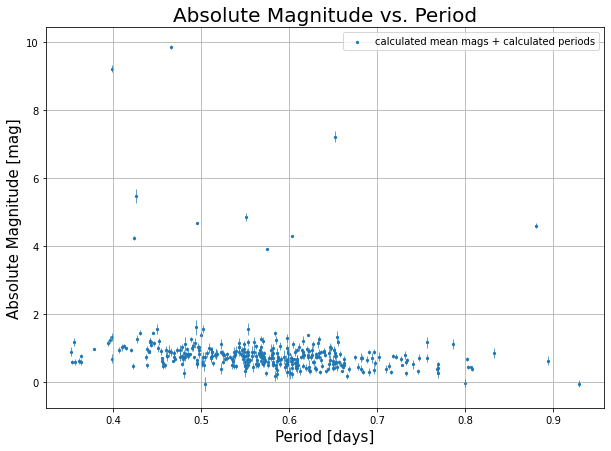

In [33]:
plt.figure(figsize = (10,7))
bailer_jones_d = df['r_med_geo']
errors_d = (df['r_hi_geo'] - df['r_lo_geo'])/2
errors_m = 5 * (1/np.log(10)) * errors_d / bailer_jones_d

plt.scatter(periods, G_band_absolute_magnitudes, s = 5, label = 'calculated mean mags + calculated periods')
plt.errorbar(periods, G_band_absolute_magnitudes, yerr = errors_m, fmt = 'none', elinewidth = 0.7)

'''periods_df = df['pf']
magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(bailer_jones_d) + 5
plt.scatter(periods_df, M, s = 5, label = 'Data table')'''

plt.legend()
plt.grid()
plt.xlabel('Period [days]', size = 15)
plt.ylabel('Absolute Magnitude [mag]', size = 15)
plt.title('Absolute Magnitude vs. Period', size = 20)

## Problem 17 (crude G magnitude cut)

In [34]:
#new query
query = """SELECT TOP 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10 

AND gaia_source.astrometric_excess_noise < 1
AND gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)
AND gaia_source.phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2)
AND vari_rrlyrae.int_average_g - 5 * LOG10(gaiaedr3_distance.r_med_geo) + 5 < 3.5

AND pf IS NOT NULL 


"""

'AND SQRT(gaia_source.astrometric_chi_2_al/(astrometric_n_good_obs_al - 5)) < 1.2'
'AND 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2) < gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)'

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df


source_id,parallax,parallax_over_error,b,l,pf,pf_error,int_average_g,int_average_g_error,r_med_geo,r_hi_geo,r_lo_geo
,mas,,deg,deg,d,d,mag,mag,pc,pc,pc
int64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32
5082275006547809536,0.26809523957285347,16.220354,-51.47302371332451,219.87363079008162,0.5599589021541818,2.247266e-06,13.462838,0.003699631,3251.9053,3426.7776,3081.9224
5083946363004134144,0.5946781130908292,34.110825,-49.8322488970572,218.64881795286897,0.49750448582774803,2.4864212e-06,12.052523,0.0041959034,1607.3054,1652.5009,1558.1212
5094203642556959744,0.5017024595959433,24.04988,-45.693940849004406,214.1579182947437,0.6088124847419696,1.978491e-06,11.987591,0.0063922284,1885.8368,1978.6187,1809.5858
5094426804761045248,0.4086511433886336,26.117859,-46.35806582585982,213.79029199767078,0.6021733362599567,5.8916344e-06,12.443733,0.010910096,2297.7349,2390.4333,2213.6853
5098240155900394112,0.36106562106170625,20.336185,-55.33792695831056,215.75720474779882,0.629624359508207,8.102741e-06,12.518427,0.01379541,2607.2856,2714.123,2500.5015
584371601026374272,0.5023216203946383,29.193705,30.31802198627761,221.77253179679283,0.636424023604154,2.2620877e-06,12.259682,0.0019192556,1884.4073,1942.4014,1837.6722
586254622063844736,0.413362843606383,23.04635,38.44674515040859,226.041203484812,0.6028511675471729,3.140523e-06,12.420674,0.0035330036,2271.9607,2378.0483,2172.1985
3844396540563624832,0.613325049466868,29.34836,35.20937516561878,231.9936973061365,0.6343515568959289,3.3973001e-06,11.697707,0.0032393388,1524.2205,1566.2969,1467.515


In [35]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]



In [36]:
periods = []
G_band_absolute_magnitudes = []
for dl_key in dl_keys:
    periods.append(get_period(dl_key))
    source_id = get_source_id(dl_key)
    
    df.add_index('source_id')
    t = df.loc[source_id]
    d = t['r_med_geo']
    
    absolute_mags = get_absolute_mag(dl_key, d)
    G_band_absolute_magnitudes.append(absolute_mags)

/tmp/ipykernel_1148/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


Text(0.5, 1.0, 'Absolute Magnitude vs. Period')

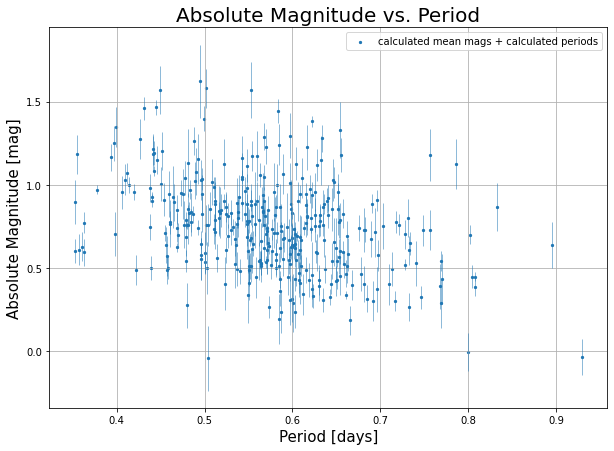

In [37]:
plt.figure(figsize = (10,7))
plt.scatter(periods, G_band_absolute_magnitudes, s = 5, label = 'calculated mean mags + calculated periods')
bailer_jones_d = df['r_med_geo']
errors_d = (df['r_hi_geo'] - df['r_lo_geo'])/2
errors_m = 5 * (1/np.log(10)) * errors_d / bailer_jones_d
plt.errorbar(periods, G_band_absolute_magnitudes, yerr = errors_m, fmt = 'none', elinewidth = 0.5)

'''periods_df = df['pf']
magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(bailer_jones_d) + 5
plt.scatter(periods_df, M, s = 5, label = 'Data table')
'''

plt.legend()
plt.grid()
plt.xlabel('Period [days]', size = 15)
plt.ylabel('Absolute Magnitude [mag]', size = 15)
plt.title('Absolute Magnitude vs. Period', size = 20)



## Problem 18 (Plot Period-absolute magnitude with parallax)

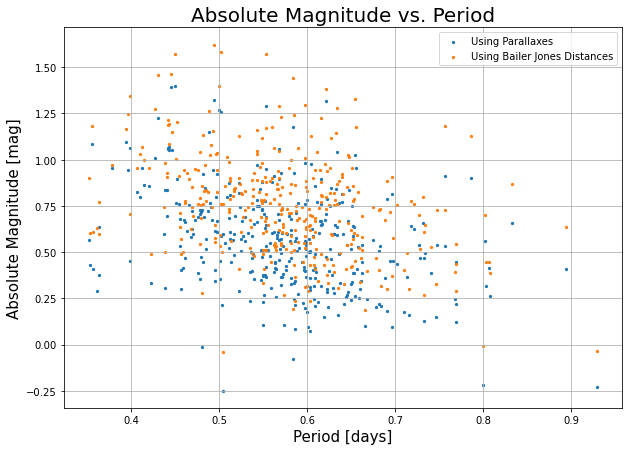

In [38]:
parallaxes = df['parallax']
distances_parallaxes = 1/parallaxes * 1000

magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(distances_parallaxes) + 5
plt.figure(figsize = (10,7))
plt.scatter(periods, M, s = 5, label = 'Using Parallaxes')
plt.scatter(periods, G_band_absolute_magnitudes, s = 5, label = 'Using Bailer Jones Distances')
plt.grid()
plt.xlabel('Period [days]', size = 15)
plt.ylabel('Absolute Magnitude [mag]', size = 15)
plt.title('Absolute Magnitude vs. Period', size = 20)
plt.legend()

## Problem 19 MCMC

In [39]:
import random

def gaussian(x, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(mu - x)**2 / (2*sigma**2))

def target(x):
    mu = 1
    sigma = 0.1
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(mu - x)**2 / (2*sigma**2))



steps = 10000

x = 2

xs = []

xs.append(x)

for t in range(steps):
    current_x = xs[t]
    
    proposed_x = np.random.normal(loc = current_x)

    A = target(proposed_x)/target(current_x)
    
    #print(A)
    
    probability = min(A, 1)
    
    decision = random.choices([1,0], [probability, 1-probability])
    
    
    if(decision[0] == 1):
        xs.append(proposed_x)
        
    if(decision[0] == 0):
        xs.append(current_x)
   


Text(0, 0.5, 'counts (normalized)')

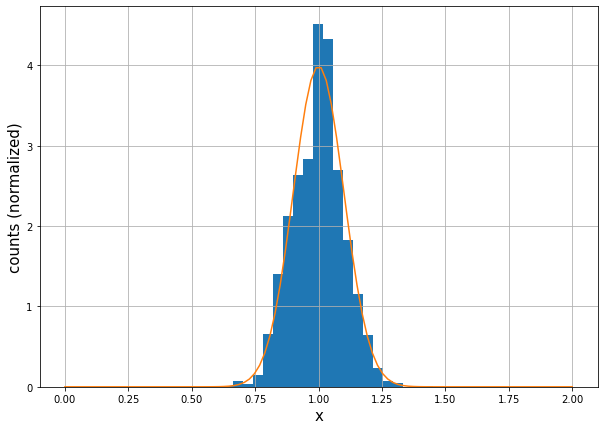

In [40]:
t = np.linspace(0, 2, 100)
y = target(t)
plt.figure(figsize = (10,7))
plt.grid()
plt.hist(xs, bins = 40, density = True)
plt.plot(t,y)
plt.xlabel('x',size = 15)
plt.ylabel('counts (normalized)', size = 15)

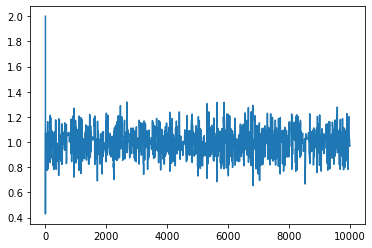

In [41]:
t = np.linspace(0, steps+1, steps+1)
plt.plot(t, xs)

In [128]:
def model(P, a, b):
    
    return a*np.log(P) + b

steps = 10000

data = [0,0]
data[0] = np.array(periods)
data[1] = np.array(G_band_absolute_magnitudes)

def likelihood(a, b, sigma):
    
    return np.prod(1/(np.sqrt(2*np.pi*sigma**2)) * np.exp(-(data[1] - a*data[0] - b)**2 / (2*sigma**2)))
    

a = -0.5
b = 1.2
sigma = 0.4

a_list = []
b_list = []
sigma_list = []

a_list.append(a)
b_list.append(b)
sigma_list.append(sigma)

for t in range(steps):
    
    current_a = a_list[t]
    current_b = b_list[t]
    current_sigma = sigma_list[t]
    
    delta = 1.5e-2
    
    proposed_a = current_a + delta*np.random.normal()
    proposed_b = current_b + delta*np.random.normal()
    proposed_sigma = current_sigma + delta*np.random.normal()

    #uniform prior
    
    proposed_posterior = likelihood(proposed_a, proposed_b, proposed_sigma)
    current_posterior = likelihood(current_a, current_b, current_sigma)
    
    
    A = proposed_posterior/current_posterior
    
    
    probability = min(A, 1)
    
    decision = random.choices([1,0], [probability, 1-probability])
    
    if(decision[0] == 1):
        a_list.append(proposed_a)
        b_list.append(proposed_b)
        sigma_list.append(proposed_sigma)
        
    if(decision[0] == 0):
        a_list.append(current_a)
        b_list.append(current_b)
        sigma_list.append(current_sigma)
        
        



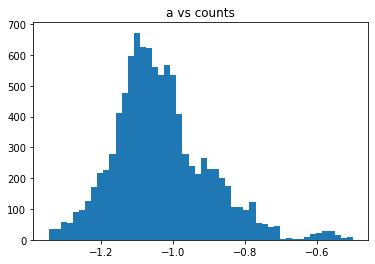

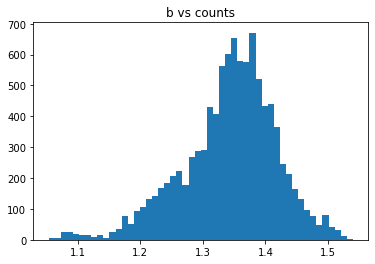

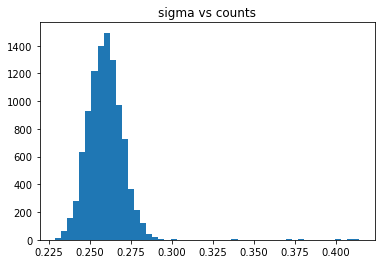

In [129]:
plt.hist(a_list, bins = 50)
plt.title('a vs counts')
plt.figure()
plt.hist(b_list, bins = 50)
plt.title('b vs counts')
plt.figure()
plt.hist(sigma_list, bins = 50)
plt.title('sigma vs counts')
plt.show()

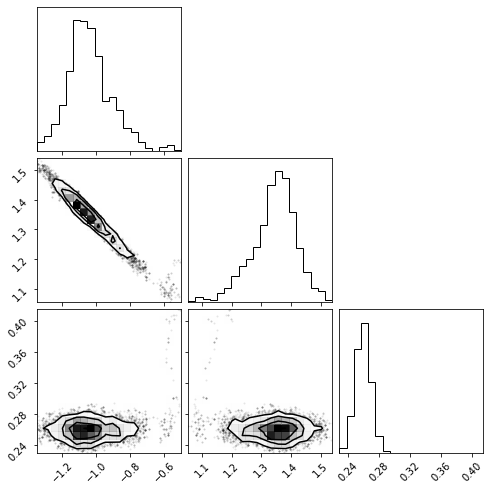

In [130]:
import corner

samples = np.vstack(np.transpose([a_list, b_list, sigma_list]))
figure = corner.corner(samples)

In [ ]:
apick = []
bpick = []
sigmapick = []
for i in range(50):
    apick.append(np.choice(a_list))
    bpick.append(np.choice(b_list))
    sigmapick.append(np.choice(sigma_list))
    
